In [804]:
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [805]:
df = pd.read_csv('DHC_E_ZG0SKK.csv', delimiter=',', parse_dates=['Fecha/Hora'], index_col='Fecha/Hora')

# Definir un umbral para considerar radiación significativa
umbral_radiacion = 5  # W/m^2

# Filtrar las horas con radiación significativa
df = df[(df['ghi'] > umbral_radiacion)]

In [806]:
# Filtrar los datos para incluir solo aquellos entre las 7:00 y las 19:00 horas
df_filtered = df.between_time('07:00', '19:00').copy()

# Seleccionamos las columnas relevantes para el gráfico
df_selected = df_filtered[['dir', 'dif', 'sct', 'ghi', 'dirh', 'difh']].copy()

# Columna de hora para agrupar los datos por hora del día
df_selected.loc[:, 'Hora'] = df_selected.index.hour
# Agrupar los datos por hora y calcular la media para cada hora
df_grouped = df_selected.groupby('Hora').mean()
# Mostrar los datos agrupados
print(df_grouped.head())

             dir        dif       sct         ghi        dirh       difh
Hora                                                                    
7      18.193821  24.082877  0.357779   60.905479   36.218403  24.687075
8     107.184490  46.763737  0.956191  162.809380  114.872483  47.936897
9     264.918295  74.585818  2.022485  344.366939  267.910135  76.456804
10    456.041031  83.983080  3.151868  536.640169  450.550304  86.089865
11    657.160036  87.476870  4.278286  728.442121  638.770839  89.671282


### Gráfico Irradiancia

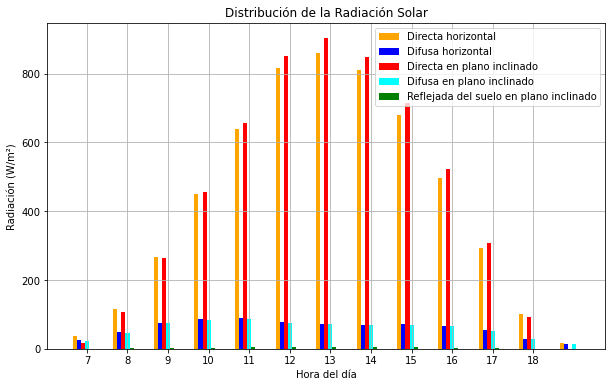

In [807]:
plt.figure(figsize=(10, 6))

plt.bar(df_grouped.index - 0.3, df_grouped['dirh'], width=0.1, label='Directa horizontal', color='orange')
plt.bar(df_grouped.index - 0.2, df_grouped['difh'], width=0.1, label='Difusa horizontal', color='blue')
plt.bar(df_grouped.index - 0.1, df_grouped['dir'], width=0.1, label='Directa en plano inclinado', color='red')
plt.bar(df_grouped.index, df_grouped['dif'], width=0.1, label='Difusa en plano inclinado', color='cyan')
plt.bar(df_grouped.index + 0.1, df_grouped['sct'], width=0.1, label='Reflejada del suelo en plano inclinado', color='green')

plt.xlabel('Hora del día')
plt.ylabel('Radiación (W/m²)')
plt.title('Distribución de la Radiación Solar')
plt.xticks(range(7, 19))
plt.legend()
plt.grid(True)

plt.savefig('C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/distribucion.png', dpi = 150, transparent= True, bbox_inches = 'tight')
plt.show()


### Función de la Radiación Extraterrestre

In [808]:
def extraterrestrial_radiation(n, phi, hour):
    G_sc = 1367  # Constante Solar en W/m^2
    # Declinación solar
    delta = 23.45 * math.sin(math.radians(360 * (n - 81) / 365))
    #Angulo horario
    h = 15 * (hour - 12)
    # Convertir phi y delta a radianes
    phi = math.radians(phi)
    delta = math.radians(delta)
    h = math.radians(h)
    #Angulo cenital
    cos_theta_z = math.sin(phi) * math.sin(delta) + math.cos(phi) * math.cos(delta) * math.cos(h)
    I_0 = G_sc * (1 + 0.033 * math.cos(math.radians(360 * n / 365))) * cos_theta_z

    return I_0

In [809]:
# Agrupar los datos
df_filtered['Hora'] = df_filtered.index.hour
df_filtered['Dia_del_Año'] = df_filtered.index.dayofyear
phi = -18.4783  # Latitud de Arica
df_filtered['I_0'] = df_filtered.apply(lambda row: extraterrestrial_radiation(row['Dia_del_Año'], phi, row['Hora']), axis=1)

# Índice de claridad K_t
df_filtered['Kt'] = df_filtered['ghi'] / df_filtered['I_0']

# Eliminar filas con valores nulos
df_filtered.dropna(inplace=True)

# Identificar y eliminar outliers (por ejemplo, utilizando el rango intercuartílico)
Q1 = df_filtered['Kt'].quantile(0.25)
Q3 = df_filtered['Kt'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df_filtered[~((df_filtered['Kt'] < (Q1 - 1.5 * IQR)) | (df_filtered['Kt'] > (Q3 + 1.5 * IQR)))]

In [810]:
# Clasificar las condiciones del tiempo
# Usar Kt como CSR
df_filtered['CSR'] = df_filtered['Kt']

# Definir umbrales para clasificar el tiempo como nublado, parcialmente nublado o soleado
def clasificar_tiempo(row):
    if row['CSR'] > 0.8:
        return 'soleado'
    elif row['CSR'] < 0.3:
        return 'nublado'
    else:
        return 'parcialmente_nublado'

df_filtered['Tipo_Tiempo'] = df_filtered.apply(clasificar_tiempo, axis=1)

# Asegurarse de que las longitudes coincidan agrupando por la misma frecuencia
duracion_nublada = df_filtered[df_filtered['Tipo_Tiempo'] == 'nublado'].resample('D').size()
duracion_parcialmente_nublada = df_filtered[df_filtered['Tipo_Tiempo'] == 'parcialmente_nublado'].resample('D').size()
duracion_total_sol = df_filtered.resample('D').size()

# Crear un DataFrame para almacenar las características
caracteristicas = pd.DataFrame(index=duracion_total_sol.index)
caracteristicas['F1'] = duracion_nublada / duracion_total_sol
caracteristicas['F2'] = duracion_parcialmente_nublada / duracion_total_sol

# Calcular CSR promedio y desviación estándar en condiciones nubladas
csr_nublado = df_filtered[df_filtered['Tipo_Tiempo'] == 'nublado'].resample('D')['CSR']
caracteristicas['F3'] = csr_nublado.mean()
caracteristicas['F4'] = csr_nublado.std()

# Calcular la tasa de cambio del CSR en condiciones nubladas
df_filtered['dCSR'] = df_filtered['CSR'].diff().abs()
tasa_cambio_nublado = df_filtered[df_filtered['Tipo_Tiempo'] == 'nublado'].resample('D')['dCSR']
caracteristicas['F5'] = tasa_cambio_nublado.max()
caracteristicas['F6'] = tasa_cambio_nublado.mean()

# Filtrar filas no nulas para el clustering
caracteristicas_filtradas = caracteristicas.dropna()
print(caracteristicas_filtradas)

                  F1        F2        F3        F4        F5        F6
Fecha/Hora                                                            
2004-01-02  0.153846  0.384615 -0.100206  0.247603  1.822425  1.083771
2004-01-03  0.384615  0.153846  0.064712  0.210054  1.857549  0.480145
2004-01-04  0.461538  0.230769  0.107090  0.219206  0.863470  0.351181
2004-01-05  0.307692  0.230769  0.039407  0.237066  1.883151  0.608760
2004-01-06  0.384615  0.461538  0.144146  0.247808  1.897272  0.623834
...              ...       ...       ...       ...       ...       ...
2016-12-03  0.166667  0.333333  0.169983  0.080022  1.139845  0.626506
2016-12-05  0.230769  0.307692  0.073910  0.100317  1.305245  0.839768
2016-12-06  0.230769  0.307692  0.075026  0.121063  1.327163  0.519908
2016-12-17  0.307692  0.230769  0.076265  0.164901  1.514117  0.472181
2016-12-25  0.153846  0.384615 -0.058017  0.234941  1.669920  0.996933

[3360 rows x 6 columns]


In [811]:
# Función para clasificar las fechas por estaciones
def clasificar_estacion(fecha):
    if (fecha.month == 12 and fecha.day >= 21) or (fecha.month in [1, 2]) or (fecha.month == 3 and fecha.day <= 20):
        return 'Verano'
    elif (fecha.month == 3 and fecha.day >= 21) or (fecha.month in [4, 5]) or (fecha.month == 6 and fecha.day <= 20):
        return 'Otoño'
    elif (fecha.month == 6 and fecha.day >= 21) or (fecha.month in [7, 8]) or (fecha.month == 9 and fecha.day <= 20):
        return 'Invierno'
    else:
        return 'Primavera'

# Clasificar las fechas por estaciones
df_filtered['Estacion'] = df_filtered.index.map(clasificar_estacion)

# Crear un dataframe para cada estación
df_verano = df_filtered[df_filtered['Estacion'] == 'Verano']
df_otono = df_filtered[df_filtered['Estacion'] == 'Otoño']
df_invierno = df_filtered[df_filtered['Estacion'] == 'Invierno']
df_primavera = df_filtered[df_filtered['Estacion'] == 'Primavera']

# Función para aplicar k-means y graficar los resultados
def aplicar_kmeans_y_graficar(df, estacion):
    # Definir las características para el clustering
    caracteristicas = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6']]
    # Normalizar las características
    caracteristicas_normalizadas = scaler.fit_transform(caracteristicas)

In [812]:
# Función para calcular características
def calcular_caracteristicas(dfs):
    # Agrupación y cálculo de características
    duracion_nublada = dfs[dfs['Tipo_Tiempo'] == 'nublado'].resample('D').size()
    duracion_parcialmente_nublada = dfs[dfs['Tipo_Tiempo'] == 'parcialmente_nublado'].resample('D').size()
    duracion_total_sol = dfs.resample('D').size()

    caracteristicas = pd.DataFrame(index=duracion_total_sol.index)
    caracteristicas['F1'] = duracion_nublada / duracion_total_sol
    caracteristicas['F2'] = duracion_parcialmente_nublada / duracion_total_sol
    csr_nublado = dfs[dfs['Tipo_Tiempo'] == 'nublado'].resample('D')['CSR']
    caracteristicas['F3'] = csr_nublado.mean()
    caracteristicas['F4'] = csr_nublado.std()
    tasa_cambio_nublado = dfs[dfs['Tipo_Tiempo'] == 'nublado'].resample('D')['dCSR']
    caracteristicas['F5'] = tasa_cambio_nublado.max()
    caracteristicas['F6'] = tasa_cambio_nublado.mean()
    
    return caracteristicas

# Calcular características por estación
caracteristicas_verano = calcular_caracteristicas(df_verano)
caracteristicas_otono = calcular_caracteristicas(df_otono)
caracteristicas_invierno = calcular_caracteristicas(df_invierno)
caracteristicas_primavera = calcular_caracteristicas(df_primavera)

# Normalizar características
def normalizar_caracteristicas(caracteristicas):
    return (caracteristicas - caracteristicas.mean()) / caracteristicas.std()

caracteristicas_verano_normalizadas = normalizar_caracteristicas(caracteristicas_verano.dropna())
caracteristicas_otono_normalizadas = normalizar_caracteristicas(caracteristicas_otono.dropna())
caracteristicas_invierno_normalizadas = normalizar_caracteristicas(caracteristicas_invierno.dropna())
caracteristicas_primavera_normalizadas = normalizar_caracteristicas(caracteristicas_primavera.dropna())

### Método del Codo

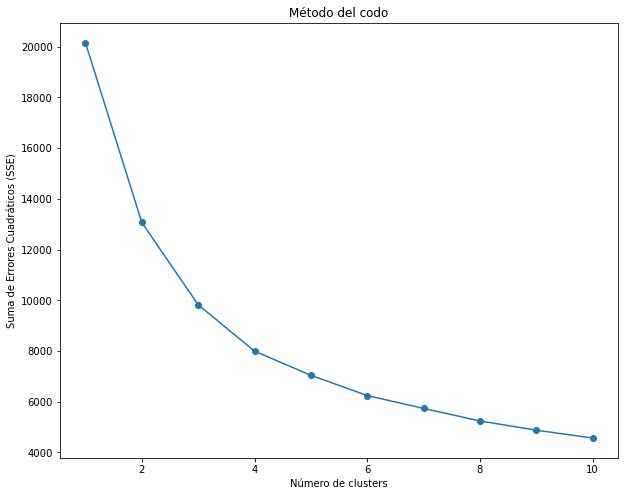

In [813]:
#Variables relevantes para el clustering
variables = caracteristicas_filtradas
df_normalized = scaler.fit_transform(variables)
# Método del codo
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_normalized)
    sse.append(kmeans.inertia_)

#Resultado del método del codo
plt.figure(figsize=(10, 8))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.title('Método del codo')
plt.savefig('C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/codo.png', dpi = 150, transparent= True, bbox_inches = 'tight')
plt.show()

### Clusters

Para seleccionar el número óptimo de clusters utilizando el método del codo (elbow method), el criterio no es necesariamente seleccionar el menor número de SSE, sino encontrar el punto en el gráfico donde la disminución de SSE se vuelve menos pronunciada, es decir, el "codo" de la curva. Observamos la gráfica generada. El eje X representa el número de clusters \( k \) y el eje Y representa la suma de los errores cuadráticos (SSE). El punto óptimo es donde la curva comienza a aplanarse, y la reducción de SSE con el aumento de \( k \) se vuelve menos significativa. En el gráfico que proporcionaste, se puede observar que la curva de SSE disminuye rápidamente hasta \( k = 4 \) y luego la reducción se vuelve más gradual. Este punto donde la disminución de SSE empieza a ser menos pronunciada generalmente se considera el número óptimo de clusters.



In [814]:
#4 basado en el método del codo
k_optimo = 4

# Función para aplicar k-means y obtener los resultados
def aplicar_kmeans(caracteristicas_normalizadas, k_optimo):
    kmeans = KMeans(n_clusters=k_optimo, random_state=0).fit(caracteristicas_normalizadas)
    caracteristicas_normalizadas['Cluster'] = kmeans.labels_
    return caracteristicas_normalizadas

caracteristicas_verano_cluster = aplicar_kmeans(caracteristicas_verano_normalizadas, k_optimo)
caracteristicas_otono_cluster = aplicar_kmeans(caracteristicas_otono_normalizadas, k_optimo)
caracteristicas_invierno_cluster = aplicar_kmeans(caracteristicas_invierno_normalizadas, k_optimo)
caracteristicas_primavera_cluster = aplicar_kmeans(caracteristicas_primavera_normalizadas, k_optimo)

# Función para graficar radar chart
def plot_radar(data, title, filename):
    labels = data.columns
    num_vars = len(labels)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for cluster in data.index:
        values = data.loc[cluster].tolist()
        values += values[:1]
        ax.fill(angles, values, alpha=0.25)
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Class {cluster}')

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Save the figure
    plt.savefig(filename)
    plt.show()

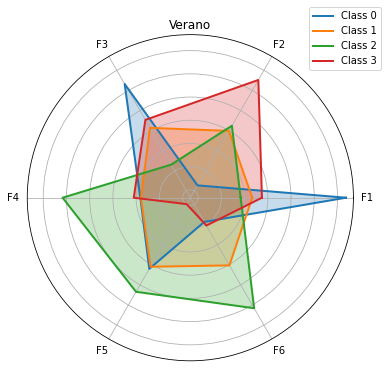

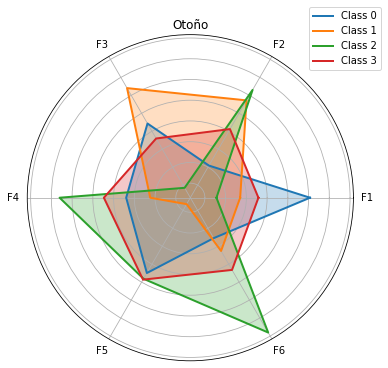

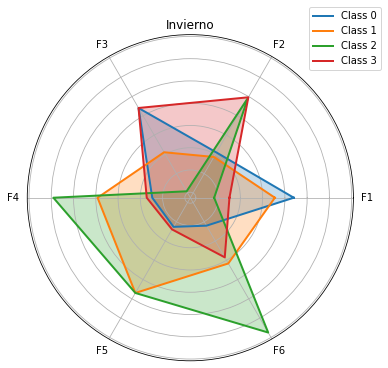

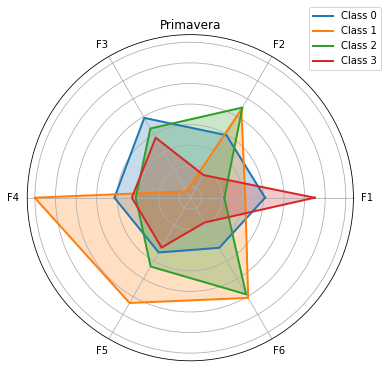

In [815]:
# Promedios por cluster para cada estación
promedios_verano = caracteristicas_verano_cluster.groupby('Cluster').mean()
promedios_otono = caracteristicas_otono_cluster.groupby('Cluster').mean()
promedios_invierno = caracteristicas_invierno_cluster.groupby('Cluster').mean()
promedios_primavera = caracteristicas_primavera_cluster.groupby('Cluster').mean()

# Graficar resultados
plot_radar(promedios_verano, 'Verano', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/verano_radar.png')
plot_radar(promedios_otono, 'Otoño','C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/otono_radar.png')
plot_radar(promedios_invierno, 'Invierno','C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/invierno_radar.png')
plot_radar(promedios_primavera, 'Primavera','C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/primavera_radar.png')


### Matriz de transición MARKOV CHAIN

In [816]:
# Función para calcular la matriz de transición de Markov
def calcular_matriz_transicion(caracteristicas_cluster, k_optimo):
    transition_matrix = np.zeros((k_optimo, k_optimo))
    clusters = caracteristicas_cluster['Cluster'].values

    for i in range(len(clusters) - 1):
        current_cluster = clusters[i]
        next_cluster = clusters[i + 1]
        transition_matrix[current_cluster, next_cluster] += 1

    # Normalizar las filas para obtener probabilidades
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    return transition_matrix

# Calcular la matriz de transición de Markov para cada estación
matriz_transicion_verano = calcular_matriz_transicion(caracteristicas_verano_cluster, k_optimo)
matriz_transicion_otono = calcular_matriz_transicion(caracteristicas_otono_cluster, k_optimo)
matriz_transicion_invierno = calcular_matriz_transicion(caracteristicas_invierno_cluster, k_optimo)
matriz_transicion_primavera = calcular_matriz_transicion(caracteristicas_primavera_cluster, k_optimo)

# Mostrar las matrices de transición de Markov
print("Matriz de Transición de Markov - Verano:")
print(matriz_transicion_verano)
print("\nMatriz de Transición de Markov - Otoño:")
print(matriz_transicion_otono)
print("\nMatriz de Transición de Markov - Invierno:")
print(matriz_transicion_invierno)
print("\nMatriz de Transición de Markov - Primavera:")
print(matriz_transicion_primavera)

Matriz de Transición de Markov - Verano:
[[0.37804878 0.26829268 0.22560976 0.12804878]
 [0.18431373 0.5372549  0.10588235 0.17254902]
 [0.09897611 0.09215017 0.70307167 0.10580205]
 [0.17333333 0.31333333 0.15333333 0.36      ]]

Matriz de Transición de Markov - Otoño:
[[0.4573991  0.12556054 0.0941704  0.32286996]
 [0.2173913  0.60869565 0.09565217 0.07826087]
 [0.25       0.05681818 0.28409091 0.40909091]
 [0.31779661 0.04661017 0.13135593 0.50423729]]

Matriz de Transición de Markov - Invierno:
[[0.55700326 0.09446254 0.02605863 0.32247557]
 [0.06615776 0.68956743 0.19338422 0.05089059]
 [0.07857143 0.51428571 0.33571429 0.07142857]
 [0.43478261 0.08695652 0.03913043 0.43913043]]

Matriz de Transición de Markov - Primavera:
[[0.38135593 0.03813559 0.31355932 0.26694915]
 [0.0617284  0.71604938 0.02469136 0.19753086]
 [0.3125     0.02916667 0.46666667 0.19166667]
 [0.32195122 0.03902439 0.25365854 0.38536585]]


In [817]:
def calcular_distribucion_estacionaria(transition_matrix):
    n = transition_matrix.shape[0]
    q = (transition_matrix - np.eye(n))
    ones = np.ones(n)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(n)
    distribucion_estacionaria = np.linalg.solve(QTQ, bQT)
    return distribucion_estacionaria

# Calcular la distribución estacionaria para cada matriz de transición
distribucion_estacionaria_verano = calcular_distribucion_estacionaria(matriz_transicion_verano)
distribucion_estacionaria_otono = calcular_distribucion_estacionaria(matriz_transicion_otono)
distribucion_estacionaria_invierno = calcular_distribucion_estacionaria(matriz_transicion_invierno)
distribucion_estacionaria_primavera = calcular_distribucion_estacionaria(matriz_transicion_primavera)

print("Distribución estacionaria - Verano:")
print(distribucion_estacionaria_verano)
print("Distribución estacionaria - Otoño:")
print(distribucion_estacionaria_otono)
print("Distribución estacionaria - Invierno:")
print(distribucion_estacionaria_invierno)
print("Distribución estacionaria - Primavera:")
print(distribucion_estacionaria_primavera)

Distribución estacionaria - Verano:
[0.19025522 0.29582367 0.33990719 0.17401392]
Distribución estacionaria - Otoño:
[0.33896882 0.17064795 0.13296716 0.35741607]
Distribución estacionaria - Invierno:
[0.28956882 0.36420839 0.13011611 0.21610667]
Distribución estacionaria - Primavera:
[0.30858835 0.11040464 0.31368073 0.26732628]


### Generación para TSRY

In [820]:
# Generación de una secuencia de estados para TSRY
def generar_tsr_sequence(matriz_transicion, clusters, n_dias=365, horas_por_dia=24):
    np.random.seed(0)

    # Obtener los clusters únicos y sus probabilidades
    clusters_unicos, counts = np.unique(clusters, return_counts=True)
    probabilidades = counts / counts.sum()

    # Seleccionar un estado inicial basado en la distribución de frecuencias de los estados
    estado_inicial = np.random.choice(clusters_unicos, p=probabilidades)
    secuencia_estados = [estado_inicial]

    # Generar la secuencia de estados basada en la matriz de transición
    for _ in range(n_dias * horas_por_dia - 1):  # Asumiendo datos por hora para un año
        estado_actual = secuencia_estados[-1]
        estado_siguiente = np.random.choice(clusters_unicos, p=matriz_transicion[int(estado_actual)])
        secuencia_estados.append(estado_siguiente)

    return secuencia_estados

# Mapear estados a días reales
def mapear_estados_a_dias(secuencia_estados, caracteristicas_cluster, clusters):
    tsry = pd.DataFrame()
    for estado in secuencia_estados:
        dia_real = caracteristicas_cluster[clusters == estado].sample(n=1)
        tsry = pd.concat([tsry, dia_real])
    
    tsry.reset_index(drop=True, inplace=True)
    return tsry

# Generar secuencias de estados para cada estación utilizando sus respectivas matrices de transición
secuencia_estados_verano = generar_tsr_sequence(matriz_transicion_verano, caracteristicas_verano_cluster['Cluster'].values)
secuencia_estados_otono = generar_tsr_sequence(matriz_transicion_otono, caracteristicas_otono_cluster['Cluster'].values)
secuencia_estados_invierno = generar_tsr_sequence(matriz_transicion_invierno, caracteristicas_invierno_cluster['Cluster'].values)
secuencia_estados_primavera = generar_tsr_sequence(matriz_transicion_primavera, caracteristicas_primavera_cluster['Cluster'].values)

# Mapear estados a días reales para cada estación
tsry_verano = mapear_estados_a_dias(secuencia_estados_verano, caracteristicas_verano_cluster, caracteristicas_verano_cluster['Cluster'].values)
tsry_otono = mapear_estados_a_dias(secuencia_estados_otono, caracteristicas_otono_cluster, caracteristicas_otono_cluster['Cluster'].values)
tsry_invierno = mapear_estados_a_dias(secuencia_estados_invierno, caracteristicas_invierno_cluster, caracteristicas_invierno_cluster['Cluster'].values)
tsry_primavera = mapear_estados_a_dias(secuencia_estados_primavera, caracteristicas_primavera_cluster, caracteristicas_primavera_cluster['Cluster'].values)


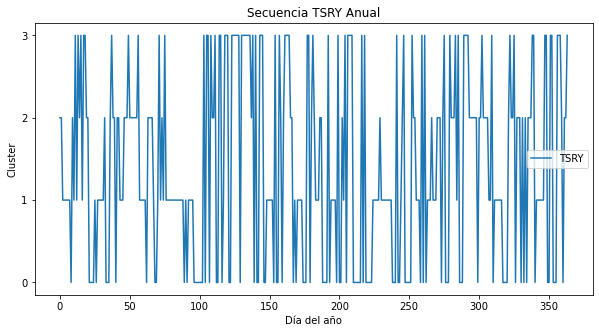

In [821]:
# Simulación de la secuencia TSRY anual
def generar_secuencia_tsry(matriz_transicion, longitud):
    estados = np.arange(matriz_transicion.shape[0])
    estado_actual = np.random.choice(estados)
    secuencia = [estado_actual]
    
    for _ in range(longitud - 1):
        estado_actual = np.random.choice(estados, p=matriz_transicion[estado_actual])
        secuencia.append(estado_actual)
    
    return secuencia

# Generar secuencia TSRY anual
longitud_anual = 365
secuencia_anual = generar_secuencia_tsry(matriz_transicion_verano, longitud_anual // 4)
secuencia_anual += generar_secuencia_tsry(matriz_transicion_otono, longitud_anual // 4)
secuencia_anual += generar_secuencia_tsry(matriz_transicion_invierno, longitud_anual // 4)
secuencia_anual += generar_secuencia_tsry(matriz_transicion_primavera, longitud_anual // 4)
# Graficar radiación solar CRS a lo largo del año
def plot_radiacion_anual(secuencia, titulo, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(secuencia, label='TSRY')
    plt.title(titulo)
    plt.xlabel('Día del año')
    plt.ylabel('Cluster')
    plt.yticks([0, 1, 2, 3])
    plt.legend()
    plt.savefig(filename)
    plt.show()

plot_radiacion_anual(secuencia_anual, 'Secuencia TSRY Anual', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/tsry_anual.png')

In [822]:
# Combinar los datos de todas las estaciones para obtener un año completo
tsry_anual = pd.concat([tsry_verano, tsry_otono, tsry_invierno, tsry_primavera]).reset_index(drop=True)

# Mostrar el TSRY
print(tsry_anual.head())

         F1        F2        F3        F4        F5        F6  Cluster
0 -0.708767  0.401293 -0.706856  1.719220  1.708082  2.071481        2
1 -0.582663  0.705067 -0.585037  0.488828  0.071513  0.587723        2
2 -0.582663  0.046890 -0.774690  1.077599  0.194428  0.823443        2
3 -0.582663  0.046890 -0.817236  1.227405  0.228425  0.882931        2
4 -0.582663  0.046890 -0.765485  1.048463  0.211285  0.826306        2


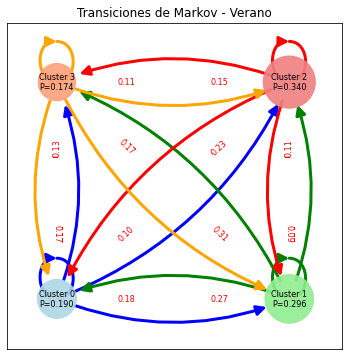

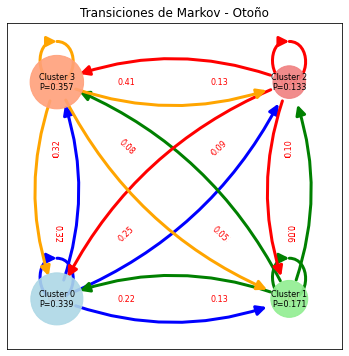

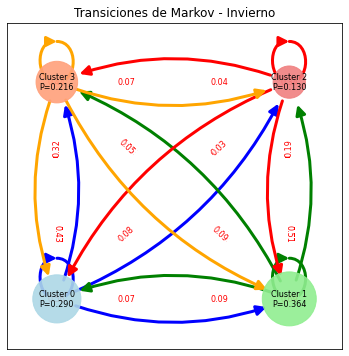

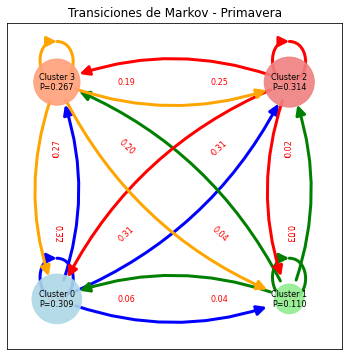

In [823]:
# Función para crear el grafo
def crear_grafo(matriz_transicion, distribucion_estacionaria, estacion, filename):
    G = nx.DiGraph()

    # Añadir nodos con la probabilidad de estar en cada estado
    for i, prob in enumerate(distribucion_estacionaria):
        G.add_node(i, label=f'Cluster {i}\nP={prob:.3f}', size=prob * 8000)

    # Añadir aristas con las probabilidades de transición
    for i in range(matriz_transicion.shape[0]):
        for j in range(matriz_transicion.shape[1]):
            if matriz_transicion[i, j] > 0:
                G.add_edge(i, j, weight=matriz_transicion[i, j], label=f'{matriz_transicion[i, j]:.2f}', color=i)
    pos = {
        0: (0.2, 0.2),
        1: (1, 0.2),
        2: (1, 1),
        3: (0.2, 1)
    }
    node_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    edge_colors = ['blue', 'green', 'red', 'orange']

    plt.figure(figsize=(6, 6))

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['size'] for node in G.nodes], node_color=node_colors, alpha=0.9)
    
    # Dibujar aristas
    edges = G.edges(data=True)
    for edge in edges:
        connectionstyle = f'arc3,rad=0.2'  # Estilo de curva
        nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], arrowstyle='-|>', arrowsize=20, edge_color=edge_colors[edge[2]['color']], width=3, min_source_margin=20, min_target_margin= 24,connectionstyle=connectionstyle)
    
    # Dibujar etiquetas de nodos
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Dibujar etiquetas de aristas
    edge_labels = nx.get_edge_attributes(G, 'label')
    pos_edge_labels = {(u, v): ((pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2) for u, v in G.edges()}
    for edge in edges:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos = 0.3, font_color='red', font_size=8,bbox=dict(facecolor='white', edgecolor='none', pad=0.5))
    
    plt.title(f'Transiciones de Markov - {estacion}')
    plt.savefig(filename)
    plt.show()

# Crear y mostrar grafos para cada estación
crear_grafo(matriz_transicion_verano, distribucion_estacionaria_verano, 'Verano', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/verano_grafo.png')
crear_grafo(matriz_transicion_otono, distribucion_estacionaria_otono, 'Otoño', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/otono_grafo.png')
crear_grafo(matriz_transicion_invierno, distribucion_estacionaria_invierno, 'Invierno', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/invierno_grafo.png')
crear_grafo(matriz_transicion_primavera, distribucion_estacionaria_primavera, 'Primavera', 'C:/Info_Camila/Camila/Universidad_2024-1/Procesos_Estocásticos/Proyecto/primavera_grafo.png')
